In [1]:
import surprise
import json
import pandas as pd
import numpy as np
import os
import random

my_seed = 2007
random.seed(my_seed)
np.random.seed(my_seed)

In [2]:
cwd = os.getcwd()
RAW_DATA_PATH = os.path.join(cwd, "Gift_Cards.csv")
data = pd.read_csv(RAW_DATA_PATH, names=['item', 'user', 'rating', 'timestamp'], parse_dates=['timestamp'],  dayfirst=True)

# Preprocess and EDA

In [3]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

In [4]:
data

,item,user,rating,timestamp
0,B001GXRQW0,APV13CM0919JD,1.0,2008-12-19
1,B001GXRQW0,A3G8U1G1V082SN,5.0,2008-12-17
2,B001GXRQW0,A11T2Q0EVTUWP,5.0,2008-12-17
3,B001GXRQW0,A9YKGBH3SV22C,5.0,2008-12-17
4,B001GXRQW0,A34WZIHVF3OKOL,1.0,2008-12-17
...,...,...,...,...
147189,B01H5PPJT4,A2K9WVQW9TLWNK,5.0,2018-09-15
147190,B01H5PPJT4,A149ALSR6TPGF7,4.0,2018-09-07
147191,B01H5PPJT4,A2Q066NZCQSCOR,5.0,2018-08-29
147192,B01H5PPJT4,A1KJLWCW7XBS8I,5.0,2018-08-18


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147194 entries, 0 to 147193
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   item       147194 non-null  object        
 1   user       147194 non-null  object        
 2   rating     147194 non-null  float64       
 3   timestamp  147194 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.5+ MB


In [6]:
data['rating'].value_counts()

5.0    126689
4.0      8700
1.0      7165
3.0      2996
2.0      1644
Name: rating, dtype: int64

In [7]:
len(data['user'].unique())

128877

<AxesSubplot:>

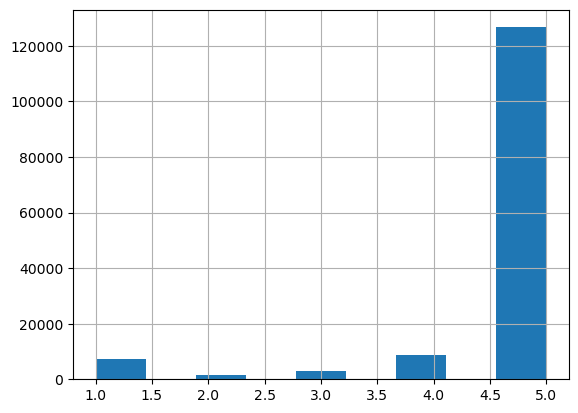

In [8]:
data['rating'].hist(bins=9)

In [9]:
ratings_item_summary = data.groupby('item')['rating'].agg(['count', 'mean', 'std'])
# ratings_item_summary.sort_values('count', ascending=False).head(10)
ratings_item_summary.head(5)

,count,mean,std
item,,,
1619923009,4,4.750000,0.500000
B001BKEWF2,1,5.000000,NaN
B001GXRQW0,706,4.090652,1.533641
B001H53QE4,8,3.625000,1.597990
B001H53QEO,3,3.000000,1.732051


<AxesSubplot:>

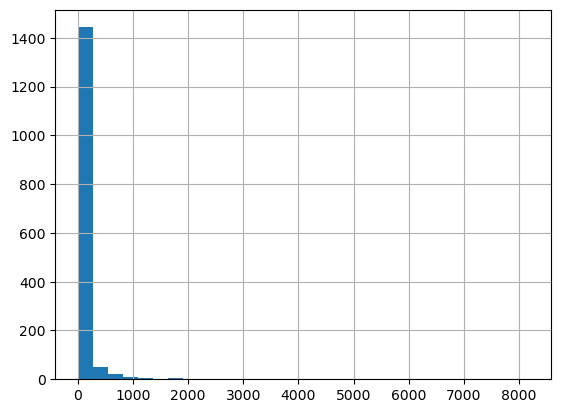

In [10]:
ratings_item_summary.sort_values(by='count')['count'].hist(bins=30)

In [11]:
ratings_user_summary = data.groupby('user')['rating'].agg(['count', 'mean', 'std'])
ratings_user_summary.head(5)

,count,mean,std
user,,,
A0095461J2PRARAMDCI,1,1.0,NaN
A0097695AYLE91ZX89FB,1,5.0,NaN
A01423305PUDQS2VV7QX,1,5.0,NaN
A0151652BYTK45B15T2R,1,5.0,NaN
A0155528TCZ6R6URPU31,1,5.0,NaN


<AxesSubplot:>

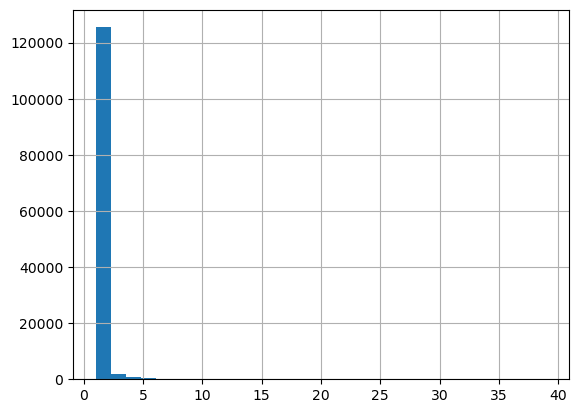

In [12]:
ratings_user_summary.sort_values(by='count')['count'].hist(bins=30)

In [13]:
reader = surprise.Reader(line_format='user item rating timestamp', rating_scale=(1, 5))

In [14]:
dataset = surprise.Dataset.load_from_df(data[["user", "item", "rating"]], reader)

In [15]:
# https://surprise.readthedocs.io/en/stable/FAQ.html#unbiased-estimate-after-tuning
# If your goal is to tune the parameters of an algorithm, you may want to spare a bit of data to have an unbiased estimation of its performances. 
# For instance you may want to split your data into two sets A and B. 
# A is used for parameter tuning using grid search, and B is used for unbiased estimation. 

raw_ratings = dataset.raw_ratings  # retrieve the raw data
# мы не шафлим рейтинги, на а обучаем макропарамметры грид серчем
# A = 75% of the data, B = 25% of the data
threshold  = int(0.75 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

# Create train and test set
dataset.raw_ratings = A_raw_ratings    # data is now the set A

In [16]:
# trainset, testset = surprise.model_selection.train_test_split(dataset, test_size=0.25, shuffle=False)

# ML
## train

In [17]:
param_grid = {
    "n_factors": [25, 40, 55],  # default 100
    "n_epochs": [10, 20],  # default 20
    "lr_all": [0.005, 0.025, 0.125],  # learning rate for all parameters. Default 0.005
    "reg_all": [0.08, 0.16, 0.32],  # regularization term for all parameters. Default 0.02
}

In [18]:
# param_grid = {
#     "n_factors": [25, ],  # default 100
#     "n_epochs": [10, ],  # default 20
#     "lr_all": [0.005, 0.025, ],  # learning rate for all parameters. Default 0.005
#     "reg_all": [0.08, 0.16, ],  # regularization term for all parameters. Default 0.02
# }

In [19]:
gs_svdpp = surprise.model_selection.GridSearchCV(surprise.SVDpp, param_grid, measures=["rmse", "mae"], cv=3, refit=True, n_jobs=-1, joblib_verbose=1)

In [20]:
%%time
gs_svdpp.fit(dataset)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   38.0s finished


CPU times: total: 34.2 s
Wall time: 40.1 s


In [21]:
pd.DataFrame(gs_svdpp.cv_results).sort_values('rank_test_rmse').head(3)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
14,0.903136,0.923562,0.907210,0.911303,0.008827,1,0.531572,0.538601,0.531070,0.533748,...,32,1.271176,0.033247,0.425490,0.012675,"{'n_factors': 25, 'n_epochs': 20, 'lr_all': 0....",25,20,0.025,0.32
32,0.903419,0.923575,0.907578,0.911524,0.008689,2,0.531246,0.538266,0.530756,0.533423,...,29,1.616667,0.013072,0.474334,0.032252,"{'n_factors': 40, 'n_epochs': 20, 'lr_all': 0....",40,20,0.025,0.32
50,0.903453,0.923653,0.907641,0.911582,0.008705,3,0.531018,0.538038,0.530359,0.533138,...,27,1.975333,0.065351,0.462334,0.007362,"{'n_factors': 55, 'n_epochs': 20, 'lr_all': 0....",55,20,0.025,0.32


In [22]:
print("RMSE score", gs_svdpp.best_score['rmse'])
print("Best Parameters", gs_svdpp.best_params['rmse'])

RMSE score 0.9113027540305102
Best Parameters {'n_factors': 25, 'n_epochs': 20, 'lr_all': 0.025, 'reg_all': 0.32}


In [23]:
algo = gs_svdpp.best_estimator["rmse"]

## predict

In [24]:
# retrain on the whole set A
trainset = dataset.build_full_trainset()
algo.fit(trainset)

In [25]:
# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on A,", end="   ")
surprise.accuracy.rmse(predictions)

Biased accuracy on A,   RMSE: 0.5699


0.5698532203714977

In [26]:
# Compute unbiased accuracy on B
testset = dataset.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print("Unbiased accuracy on B,", end=" ")
surprise.accuracy.rmse(predictions)

Unbiased accuracy on B, RMSE: 1.0159


1.0159319725050062

In [27]:
users_cnt = data.groupby('user').count()['item'].sort_values(ascending=False)
users_cnt

user
A13H0YP0J8PM6V    39
A1U1G73EI5IRZF    32
A3OHGWD8LIDZ8K    26
A1F2NKB1ZKMO2V    23
A2RTTRR421J9KG    22
                  ..
A2BLZ3GKYYMBSW     1
A2BLYJPMDGS2X2     1
A2BLVPYSLR0KBP     1
A2BLSCKD1AEWRT     1
AZZZRGMYLGFLM      1
Name: item, Length: 128877, dtype: int64

In [28]:
data[data['user'] == 'A13H0YP0J8PM6V'].head(3)

,item,user,rating,timestamp
46699,B0078EPRPE,A13H0YP0J8PM6V,5.0,2016-10-25
65665,B00AR51Y5I,A13H0YP0J8PM6V,5.0,2017-01-13
74016,B00BXLSZPM,A13H0YP0J8PM6V,5.0,2017-09-06


In [29]:
uid = 'A13H0YP0J8PM6V'
iid = 'B0078EPRPE'

pred = algo.predict(uid, iid, verbose=True)

user: A13H0YP0J8PM6V item: B0078EPRPE r_ui = None   est = 4.81   {'was_impossible': False}


In [30]:
%%time
testset = trainset.build_anti_testset()

CPU times: total: 26.3 s
Wall time: 26.4 s


In [31]:
testset[:10]

[('APV13CM0919JD', 'B002BSHDJK', 4.685882512794963),
 ('APV13CM0919JD', 'B002DN7XS4', 4.685882512794963),
 ('APV13CM0919JD', 'B002QFXC7U', 4.685882512794963),
 ('APV13CM0919JD', 'B002XNLC04', 4.685882512794963),
 ('APV13CM0919JD', 'B002YEWXZ0', 4.685882512794963),
 ('APV13CM0919JD', 'B00414Y7Y6', 4.685882512794963),
 ('APV13CM0919JD', 'B004KNWWO0', 4.685882512794963),
 ('APV13CM0919JD', 'B004KNWWUE', 4.685882512794963),
 ('APV13CM0919JD', 'B004KNWWT0', 4.685882512794963),
 ('APV13CM0919JD', 'B004KNWWQS', 4.685882512794963)]

In [33]:
# %%time
# Делать полный прогноз - слишком долго так, как len(testset) = 57,144,047
# predictions = algo.test(testset)

# predictions[:10]